## <center><ins>Trabajo Práctico 2: Criticas de peliculas</ins></center>
#### <center>*Robertuito - Redes Neuronales*</center>
##### <center>75.06 / 95.58 Organización de Datos - FIUBA</center>
##### <center>Ing. Rodríguez - 1°C 2023</center>
---
#### <center>**Grupo 31 - "Datazo":**</center>
<center> Michael Mena - 102685</center>
<center>Pablo Brocca - 104256</center>
<center>Diego Kisinovsky - 106203</center>

---
---

## Carga de datos y librerías

In [3]:
# !pip install -U pysentimiento transformers datasets accelerate evaluate # Solo ejecutar la primera vez en un nuevo entorno

In [4]:
# !pip install ipdb # # Solo ejecutar la primera vez en un nuevo entorno

In [5]:
from kaggle_secrets import UserSecretsClient
secret_value = UserSecretsClient().get_secret("apiKey")

In [6]:
import numpy as np
import pandas as pd

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay

# Preprocesamiento
from sklearn.model_selection import KFold, train_test_split

# Metricas
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Optimización de hiperparámetros
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from skopt import BayesSearchCV
from skopt.space import Categorical

# Manejo de modelos
from pickle import dump
from pickle import load

from datasets import Dataset, DatasetDict, load_dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
from transformers import PretrainedConfig
from pysentimiento.preprocessing import preprocess_tweet
import evaluate

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [7]:
df = pd.read_csv('/kaggle/input/d/michaelmenagg/dataset/train_preprocesado.csv', sep=',', header=0)
df.drop(['longitud'], axis=1, inplace=True)
df = df.rename(columns={'review_es': 'text', 'sentimiento': 'label'})
df.head()

,text,label
0,Uno de los otros críticos ha mencionado que de...,1
1,Una pequeña pequeña producción.La técnica de f...,1
2,Pensé que esta era una manera maravillosa de p...,1
3,"Básicamente, hay una familia donde un niño peq...",0
4,"El ""amor en el tiempo"" de Petter Mattei es una...",1


### Definición de funciones

In [8]:
#Funcion para evaluar los modelos
def evaluate_model(model, x, y, splits=5, repeats=2, metric='f1'):
    cv = RepeatedStratifiedKFold(n_splits=splits, n_repeats=repeats, random_state=1)
    scores = cross_val_score(model, x, y, scoring=metric, cv=cv, verbose=1, n_jobs=-1, error_score='raise')
    return scores

In [9]:
def preprocessTweet(ds):
    return ds.map(lambda ex: {"text": preprocess_tweet(ex["text"], lang="es")})

In [10]:
def preprocess_dataset(dataset, tokenizer):
    preprocessed_dataset = preprocessTweet(dataset)
    tokenized_dataset = preprocessed_dataset.map(
        lambda batch: tokenizer(batch["text"],
                                #padding="max_length", 
                                #max_length=150,
                                padding=False,
                                truncation=True
                               ),
        batched=True,
        batch_size=32
    )
    return tokenized_dataset

In [11]:
f1_metric = evaluate.load("f1")
recall_metric = evaluate.load("recall")

def compute_metrics (eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis = -1)
    
    results = {}
    results.update(f1_metric.compute(predictions=preds, references = labels, average="macro"))
    results.update(recall_metric.compute(predictions=preds, references = labels, average="macro"))
    return results

## Armado y entrenamiento

### Preparación de features:

In [12]:
target = 'label'
features = 'text'

### Train-Test Split:

In [13]:
x_train, x_test, y_train, y_test = train_test_split(df[features], 
                                                    df[target], 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=df[target],
                                                    shuffle=True)

x_train, x_val, y_train, y_val = train_test_split(x_train,
                                                 y_train,
                                                 test_size=0.2,
                                                 random_state=42,
                                                 stratify=y_train,
                                                 shuffle=True)

# Verificamos cantidad de datos en cada set
print('# Datos Entrenamiento: {}'.format(len(x_train)))
print('# Datos Validación: {}'.format(len(x_val)))
print('# Datos Prueba: {}'.format(len(x_test)))

# Verificamos cómo quedaron balanceados
for split_name, split in zip(['% Positivos Entrenamiento', '% Positivos Validación', '% Positivos Prueba'], [y_train, y_val, y_test]):
    print('{}: {:.3f}'.format(split_name, pd.Series(split).value_counts(normalize=True)[1] * 100))

# Datos Entrenamiento: 32000
# Datos Validación: 8000
# Datos Prueba: 10000
% Positivos Entrenamiento: 50.000
% Positivos Validación: 50.000
% Positivos Prueba: 50.000


In [14]:
df_train = pd.concat([x_train, y_train], axis=1)
df_val = pd.concat([x_val, y_val], axis=1)
df_test = pd.concat([x_test, y_test], axis=1)

In [15]:
ds_train = Dataset.from_pandas(df_train, preserve_index=False) # Contiene 2 columnas: text (critica) y label (0 o 1)
ds_val = Dataset.from_pandas(df_val, preserve_index=False)
ds_test = Dataset.from_pandas(df_test, preserve_index=False)

In [16]:
ds = DatasetDict({"train":ds_train, "validation":ds_val, "test":ds_test})
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 32000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 8000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 10000
    })
})

### Carga del modelo pre-entrenado:

In [17]:
model_name = "pysentimiento/robertuito-base-deacc" # Elimina las tildes, a diferencia de robertuito-base-uncased

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.model_max_length = 128

In [18]:
config = PretrainedConfig.from_pretrained(model_name)
config.vocab_size = tokenizer.vocab_size

### Tokenización:

In [19]:
tokenized_ds = preprocess_dataset(ds, tokenizer)
tokenized_ds

Map:   0%|          | 0/32000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/32000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 32000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10000
    })
})

In [20]:
len(max(tokenized_ds["train"]["text"], key=len))

13464

### Entrenamiento del modelo

In [21]:
training_args = TrainingArguments(
    per_device_train_batch_size=32,
    output_dir="test_trainer",
    do_eval=True,
    evaluation_strategy="epoch",
    num_train_epochs=4,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"],
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
)

trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


{'loss': 0.4751, 'learning_rate': 4.375e-05, 'epoch': 0.5}
{'loss': 0.3429, 'learning_rate': 3.7500000000000003e-05, 'epoch': 1.0}
{'eval_loss': 0.35232624411582947, 'eval_f1': 0.8459642807684491, 'eval_recall': 0.847875, 'eval_runtime': 36.4934, 'eval_samples_per_second': 219.218, 'eval_steps_per_second': 27.402, 'epoch': 1.0}
{'loss': 0.2288, 'learning_rate': 3.125e-05, 'epoch': 1.5}
{'loss': 0.2124, 'learning_rate': 2.5e-05, 'epoch': 2.0}
{'eval_loss': 0.3016199767589569, 'eval_f1': 0.8759773968805815, 'eval_recall': 0.876, 'eval_runtime': 36.6714, 'eval_samples_per_second': 218.154, 'eval_steps_per_second': 27.269, 'epoch': 2.0}
{'loss': 0.0998, 'learning_rate': 1.8750000000000002e-05, 'epoch': 2.5}
{'loss': 0.0904, 'learning_rate': 1.25e-05, 'epoch': 3.0}
{'eval_loss': 0.447856068611145, 'eval_f1': 0.8787631419495152, 'eval_recall': 0.8788750000000001, 'eval_runtime': 36.4876, 'eval_samples_per_second': 219.253, 'eval_steps_per_second': 27.407, 'epoch': 3.0}
{'loss': 0.0439, 'lear

TrainOutput(global_step=4000, training_loss=0.19171818208694458, metrics={'train_runtime': 1776.8181, 'train_samples_per_second': 72.039, 'train_steps_per_second': 2.251, 'train_loss': 0.19171818208694458, 'epoch': 4.0})

### Analisis del modelo

In [22]:
trainer.evaluate(tokenized_ds["test"])

{'eval_loss': 0.6279823780059814, 'eval_f1': 0.877093450309967, 'eval_recall': 0.8771, 'eval_runtime': 45.2791, 'eval_samples_per_second': 220.853, 'eval_steps_per_second': 27.607, 'epoch': 4.0}


{'eval_loss': 0.6279823780059814,
 'eval_f1': 0.877093450309967,
 'eval_recall': 0.8771,
 'eval_runtime': 45.2791,
 'eval_samples_per_second': 220.853,
 'eval_steps_per_second': 27.607,
 'epoch': 4.0}

In [23]:
predict = trainer.predict(tokenized_ds["test"])
y_pred_prob = predict.predictions

# Aplicar un umbral a las probabilidades para obtener las etiquetas binarias
umbral = 0.5  # Umbral de decisión
y_pred = np.argmax(y_pred_prob, axis=1)  # Obtener la clase con la probabilidad más alta
y_pred = np.where(y_pred_prob[:, 1] >= umbral, 1, 0)  # Asignar 1 si la probabilidad de la clase positiva supera el umbral, 0 en caso contrario

In [24]:
# Calcular el f1-score en los datos de prueba
f1 = f1_score(y_test, y_pred)
print("F1-score en datos de prueba:", f1)

# Calcular la exactitud en los datos de prueba
acc = accuracy_score(y_test, y_pred)
print("Exactitud en datos de prueba:", acc)

F1-score en datos de prueba: 0.8748120677558384
Exactitud en datos de prueba: 0.8751


              precision    recall  f1-score   support

           0       0.87      0.88      0.88      5000
           1       0.88      0.87      0.87      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



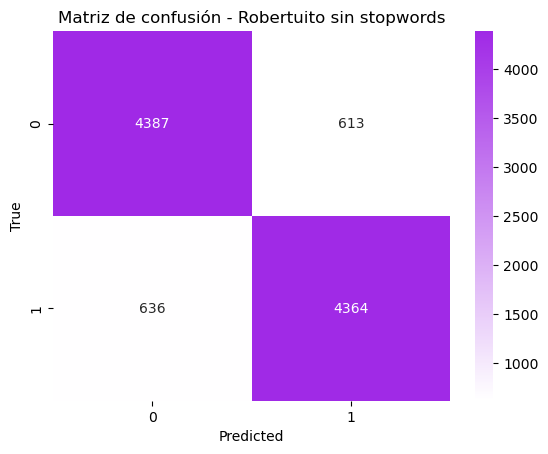

In [25]:
# Obtener la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Reporte y Matriz de Confusion
print(classification_report(y_test, y_pred))

# Definir colores
color_start = "#fff"
color_end = "#A029E6"

# Definir el mapa de colores personalizado con un degradado suave
cmap_colors = [color_start, color_end]
cmap = LinearSegmentedColormap.from_list("Custom", cmap_colors)

# Graficar la matriz de confusión con el mapa de colores personalizado
sns.heatmap(cm, cmap=cmap, annot=True, fmt='d', cbar=True)
plt.title("Matriz de confusión - Robertuito sin stopwords")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

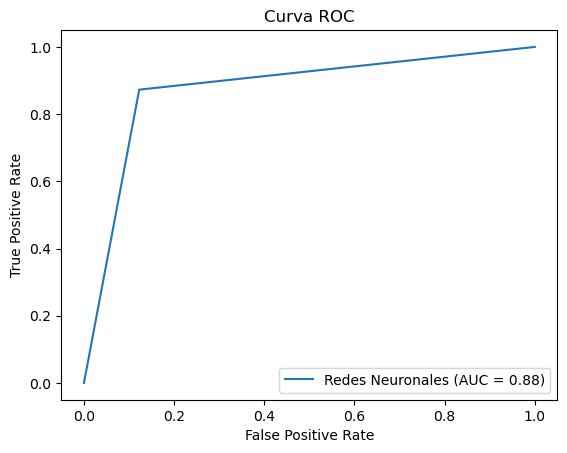

In [26]:
fpr, tpr, _ = roc_curve(y_test, y_pred) # FPR y TPR son acrónimos de "False Positive Rate" y "True Positive Rate"
roc_auc = roc_auc_score(y_test, y_pred)

roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Redes Neuronales').plot()
plt.title("Curva ROC")
plt.legend(loc="lower right")  # agregar leyenda en la esquina inferior derecha
plt.show()


## Aplicación del modelo al dataset de test

Lectura del dataset de test original para mantener id:

In [27]:
df_test_initial = pd.read_csv('/kaggle/input/d/michaelmenagg/dataset/test_preprocesado.csv', sep=',', header=0)
df_test_initial.drop(['longitud'], axis=1, inplace=True)
df_test_initial = df_test_initial.rename(columns={'review_es': 'text', 'sentimiento': 'label'})

In [28]:
df_test = Dataset.from_pandas(df_test_initial, preserve_index=False)
ds_test = DatasetDict({"text":df_test})
ds_test['text']

Dataset({
    features: ['ID', 'text'],
    num_rows: 8599
})

In [29]:
tokenized_ds_test = preprocess_dataset(ds_test, tokenizer)
tokenized_ds_test

Map:   0%|          | 0/8599 [00:00<?, ? examples/s]

Map:   0%|          | 0/8599 [00:00<?, ? examples/s]

DatasetDict({
    text: Dataset({
        features: ['ID', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8599
    })
})

In [30]:
predict_test = trainer.predict(tokenized_ds_test['text'])

# predictions: es un array bidimensional con dimensiones (n, 2), donde n es el número de muestras en el conjunto de datos de prueba.
# El primer valor representa la probabilidad de pertenecer a la clase negativa, y el segundo valor representa la probabilidad de 
# pertenecer a la clase positiva.
predict_test 

PredictionOutput(predictions=array([[-3.5350537 ,  3.0914474 ],
       [ 4.0302114 , -3.7098625 ],
       [-0.72436607,  0.39746723],
       ...,
       [ 3.6417577 , -3.3555462 ],
       [ 4.081774  , -3.603356  ],
       [ 4.1261296 , -3.5711837 ]], dtype=float32), label_ids=None, metrics={'test_runtime': 38.7123, 'test_samples_per_second': 222.126, 'test_steps_per_second': 27.769})

In [31]:
# Obtener las predicciones del modelo
predict_test_prob = predict_test.predictions

# Aplicar un umbral a las probabilidades para obtener las etiquetas binarias
umbral = 0.5  # Umbral de decisión
y_pred_final = np.argmax(predict_test_prob, axis=1)  # Obtener la clase con la probabilidad más alta
y_pred_final = np.where(predict_test_prob[:, 1] >= umbral, 1, 0)  # Asignar 1 si la probabilidad de la clase positiva supera el umbral, 0 en caso contrario

print(y_pred_final.tolist()[0:5])

[1, 0, 0, 0, 1]


In [32]:
# Calcular las frecuencias
counts = np.bincount(y_pred_final)
count_1 = counts[1]  # Frecuencia de positivos
count_0 = counts[0]  # Frecuencia de negativos

print("Resultado de la predicción: ")
print("Positivos: ", count_1)
print("Negativos: ", count_0)

Resultado de la predicción: 
Positivos:  5112
Negativos:  3487


In [33]:
# Mapeo de prediccion numerica a etiqueta (positivo, negativo)
y_pred_final = np.where(y_pred_final == 1, 'positivo', 'negativo')

In [34]:
pd.concat([df_test_initial['ID'],pd.DataFrame(data=y_pred_final, columns=['sentimiento'])], axis=1).to_csv('/kaggle/working/pred_robertuito.csv', index=False)

## Exportación del modelo

In [35]:
model.save_pretrained('/kaggle/working/model') 
# Crea una carpeta con:
# pytorch_model.bin: Contiene los pesos del modelo entrenado.
# config.json: Contiene la configuración del modelo, incluyendo los hiperparámetros utilizados durante el entrenamiento y la arquitectura del modelo.